In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
from google.colab import drive
drive.mount('content')

Mounted at content


In [3]:
sales = pd.read_csv('content/MyDrive/Service Analytics/data_processed.csv')
sales.head()

,week,sku,weekly_sales,price,price-1,price-2,feat_main_page,trend,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,functionality_2,functionality_3,functionality_4,functionality_5,functionality_6,functionality_7,functionality_8,functionality_9,functionality_10,functionality_11,functionality_12,color_blue,color_gold,color_green,color_grey,color_none,color_pink,color_purple,color_red,color_white,vendor_2,vendor_3,vendor_4,vendor_5,vendor_6,vendor_7,vendor_8,vendor_9,vendor_10
0,2016-11-14,1,110.0,10.24,9.86,10.16,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,2016-11-21,1,127.0,8.27,10.24,9.86,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,2016-11-28,1,84.0,8.83,8.27,10.24,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,2016-12-05,1,87.0,8.98,8.83,8.27,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,2016-12-12,1,64.0,10.40,8.98,8.83,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


### Simple LSTM

In [4]:
def split_simple(sequence, n_timestamp):
  X, y = [], []

  for i in range(len(sequence)):
    end = i + n_timestamp
    if end > len(sequence)-1:
      break
    sequence_x, sequence_y = sequence[i:end], sequence[end]
    X.append(sequence_x)
    y.append(sequence_y)
  return np.array(X), np.array(y)

#### Centralized

In [5]:
skus = list(sales.sku.unique())

data = dict()
colnames = [col for col in sales.columns if col not in ["week", "sku"]] #variables we don't want as predictors
for sku in skus:
  df_sku = sales[sales['sku'] == sku]
  data[sku] = {"X": df_sku[colnames].values, "y": df_sku["weekly_sales"].values}

In [6]:
cutoff = int(0.7*len(sales))

train = sales[:cutoff].reset_index(drop=True)
train = train.loc[:, 'weekly_sales'].values.reshape(-1, 1)

test = sales[cutoff:]
test = test.loc[:, 'weekly_sales'].values.reshape(-1, 1)

In [7]:
sc = StandardScaler()
train_std = sc.fit_transform(train)
test_std = sc.transform(test)

X_train, y_train = split_simple(sequence=train_std, n_timestamp=5)
X_test, y_test = split_simple(test_std, 5)

In [8]:
model = keras.models.Sequential()

model.add(keras.layers.LSTM(units = 50, return_sequences = True, input_shape = X_train.shape[1:]))
model.add(keras.layers.LSTM(units = 50))
model.add(keras.layers.Dense(1))

model.compile(loss='mse', optimizer='adam')

In [9]:
h = model.fit(X_train, y_train, epochs=15, verbose=0)

In [10]:
y_pred = sc.inverse_transform(model.predict(X_test))
y_test_inv = sc.inverse_transform(y_test)

In [11]:
print('Out of sample R2:',round(r2_score(y_test_inv, y_pred),3))
print('MSE:', round(mean_squared_error(y_test_inv, y_pred),3))

Out of sample R2: 0.134
MSE: 14569.093


#### Decentralized

Splitting into X and y values. Note that the target is contained in X values as well here - we also use `weekly_sales` in previous weeks to estimate future sales.

In [12]:
skus = list(sales.sku.unique())

data = dict()
colnames = [col for col in sales.columns if col not in ["week", "sku"]] #variables we don't want as predictors
for sku in skus:
  df_sku = sales[sales['sku'] == sku]
  data[sku] = {"X": df_sku[colnames].values, "y": df_sku["weekly_sales"].values}

Train/test split, then split the training and testing data into their X and y components. We also use a standard scaler on the train and test arrays, then add the standard scaler to a dictionary.

In [13]:
skus = list(sales.sku.unique())

X_dict = dict()
y_dict = dict()
scaler_dict = dict()

y_test_total = []
y_train_total = []

for sku in skus:
  df_sku = sales[sales['sku'] == sku]
  cutoff = int(0.7*len(df_sku))

  train = df_sku[:cutoff].reset_index(drop=True)
  train = train.loc[:, 'weekly_sales'].values.reshape(-1, 1)

  test = df_sku[cutoff:]
  test = test.loc[:, 'weekly_sales'].values.reshape(-1, 1)

  sc = StandardScaler()
  train_std = sc.fit_transform(train)
  test_std = sc.transform(test)

  X_train, y_train = split_simple(sequence=train_std, n_timestamp=5)
  X_test, y_test = split_simple(test_std, 5)

  X_dict[sku] = {'train': X_train, 'test': X_test} #adding train and test data to the dictionaries
  y_dict[sku] = {'train': y_train, 'test': y_test}
  scaler_dict[sku] = sc #adding the standard scalers to a dictionary

  y_train_total += list(sc.inverse_transform(y_train)) #adding the regular values to the train/test arrays
  y_test_total += list(sc.inverse_transform(y_test))

In [14]:
#Basic LSTM Models

basic_lstms = dict() #dictionary containing all the ridge models
y_test_pred = [] #list containing the predictions by each ridge model for the weekly sales

#General Model Architecture
model = keras.models.Sequential()

model.add(keras.layers.LSTM(units = 50, return_sequences = True, input_shape = X_train.shape[1:]))
model.add(keras.layers.LSTM(units = 50))
model.add(keras.layers.Dense(1))

model.compile(loss='mse', optimizer='adam')

for sku in skus:
  #for each SKU, fit an LSTM model
  X_train, y_train = X_dict[sku]['train'], y_dict[sku]['train']
  X_test = X_dict[sku]['test']

  sc = scaler_dict[sku] #pull the standard scaler for that SKU

  basic_lstms[sku] = model.fit(X_train, y_train, epochs=5, verbose=0)
  y_test_pred += list(sc.inverse_transform(model.predict(X_test)))
  if sku%5 == 0:
    print(sku, 'SKU models created')

5 SKU models created
10 SKU models created
15 SKU models created
20 SKU models created
25 SKU models created
30 SKU models created
35 SKU models created
40 SKU models created


In [15]:
len(y_test_total), len(y_test_pred)

(1100, 1100)

In [16]:
print('Out of sample R2:',round(r2_score(y_test_total, y_test_pred),3))
print('MSE:', round(mean_squared_error(y_test_total, y_test_pred),3))

Out of sample R2: 0.417
MSE: 76465.349


In [17]:
def create_basic_lstm(timestamp, n_units, n_layers):
  X_dict = dict()
  y_dict = dict()
  scaler_dict = dict()

  y_test_total = []
  y_train_total = []

  for sku in skus:
    df_sku = sales[sales['sku'] == sku]
    cutoff = int(0.7*len(df_sku))

    train = df_sku[:cutoff].reset_index(drop=True)
    train = train.loc[:, 'weekly_sales'].values.reshape(-1, 1)

    test = df_sku[cutoff:]
    test = test.loc[:, 'weekly_sales'].values.reshape(-1, 1)

    sc = StandardScaler()
    train_std = sc.fit_transform(train)
    test_std = sc.transform(test)

    X_train, y_train = split_simple(sequence=train_std, n_timestamp=timestamp)
    X_test, y_test = split_simple(test_std, timestamp)

    X_dict[sku] = {'train': X_train, 'test': X_test} #adding train and test data to the dictionaries
    y_dict[sku] = {'train': y_train, 'test': y_test}
    scaler_dict[sku] = sc #adding the standard scalers to a dictionary

    y_train_total += list(sc.inverse_transform(y_train)) #adding the regular values to the train/test arrays
    y_test_total += list(sc.inverse_transform(y_test))


  basic_lstms = dict() #dictionary containing all the models
  y_test_pred = [] #list containing the predictions by each model for the weekly sales

  #Model Architecture
  model = keras.models.Sequential()
  model.add(keras.layers.LSTM(units = n_units, return_sequences = True, input_shape = X_train.shape[1:]))
  for layer in range(n_layers-2):
    model.add(keras.layers.LSTM(units = n_units, return_sequences=True))
  model.add(keras.layers.LSTM(units = n_units))
  model.add(keras.layers.Dense(1))

  model.compile(loss='mse', optimizer='adam')

  for sku in skus:
    #for each SKU, fit an LSTM model
    X_train, y_train = X_dict[sku]['train'], y_dict[sku]['train']
    X_test = X_dict[sku]['test']

    sc = scaler_dict[sku] #pull the standard scaler for that SKU

    basic_lstms[sku] = model.fit(X_train, y_train, epochs=5, verbose=0)
    y_test_pred += list(sc.inverse_transform(model.predict(X_test)))
    
  print('Out of sample R2:',round(r2_score(y_test_total, y_test_pred),3))
  print('MSE:', round(mean_squared_error(y_test_total, y_test_pred),3))

In [18]:
create_basic_lstm(5, 50, 2)

Out of sample R2: 0.418
MSE: 76317.515


In [19]:
timestamps = [2, 3, 4, 5]
units = [20, 50, 75, 100]
layers = [1, 2, 3, 4]

import random
for i in range(5):
  t = random.choice(timestamps)
  u = random.choice(units)
  l = random.choice(layers)
  create_basic_lstm(t, u, l)
  print(f'Timestamps: {t}, Units: {u}, Layers: {l}')
  print()

Out of sample R2: 0.353
MSE: 76460.046
Timestamps: 2, Units: 100, Layers: 2

Out of sample R2: 0.427
MSE: 69939.825
Timestamps: 3, Units: 20, Layers: 3

Out of sample R2: 0.389
MSE: 80167.455
Timestamps: 5, Units: 50, Layers: 4

Out of sample R2: 0.41
MSE: 72075.639
Timestamps: 3, Units: 100, Layers: 3

Out of sample R2: 0.365
MSE: 74986.936
Timestamps: 2, Units: 50, Layers: 1



It looks unlikely that a simple LSTM model will outperform the optimized Ridge Regression Model.

### Multi-Input LSTM

In [20]:
def split_advanced(sequence, n_timestamp, target):
  X, y = [], []

  for i in range(len(sequence)):
    end = i+n_timestamp
    if end > len(sequence)-1:
      break
    sequence_x, sequence_y = sequence[i:end], target[end]
    X.append(sequence_x)
    y.append(sequence_y)
  return np.array(X), np.array(y)

In [21]:
train = sales[:cutoff].reset_index(drop=True)
target_train = train[['weekly_sales']].values
train = train.drop(['week', 'sku'], axis=1).values

test = sales[:cutoff].reset_index(drop=True)
target_test = test[['weekly_sales']].values
test = test.drop(['week', 'sku'], axis=1).values

In [22]:
sc = StandardScaler()
sc2 = StandardScaler()

train_std = sc.fit_transform(train)
test_std = sc.transform(test)

target_train_std = sc2.fit_transform(target_train)
target_test_std = sc2.transform(target_test)

In [23]:
X_train, y_train = split_advanced(train_std, 5, target_train_std)
X_test, y_test = split_advanced(test_std, 5, target_test_std)

In [24]:
model = keras.models.Sequential()

model.add(keras.layers.LSTM(50, return_sequences=True, input_shape = X_train.shape[1:]))
model.add(keras.layers.LSTM(units=50))
model.add(keras.layers.Dense(1))

model.compile(loss = 'mse', optimizer = 'adam')

In [25]:
h = model.fit(X_train, y_train, epochs=10)

Epoch 1/10
2/2 [==============================] - 3s 13ms/step - loss: 0.6271
Epoch 2/10
2/2 [==============================] - 0s 10ms/step - loss: 0.5212
Epoch 3/10
2/2 [==============================] - 0s 10ms/step - loss: 0.4561
Epoch 4/10
2/2 [==============================] - 0s 10ms/step - loss: 0.3862
Epoch 5/10
2/2 [==============================] - 0s 10ms/step - loss: 0.3446
Epoch 6/10
2/2 [==============================] - 0s 10ms/step - loss: 0.3160
Epoch 7/10
2/2 [==============================] - 0s 11ms/step - loss: 0.3235
Epoch 8/10
2/2 [==============================] - 0s 11ms/step - loss: 0.3102
Epoch 9/10
2/2 [==============================] - 0s 11ms/step - loss: 0.3058
Epoch 10/10
2/2 [==============================] - 0s 11ms/step - loss: 0.3017


In [26]:
y_pred = model.predict(X_test)

y_test_inv = sc2.inverse_transform(y_test)
y_pred_inv = sc2.inverse_transform(y_pred)

In [27]:
print('Out of sample R2:',round(r2_score(y_test_inv, y_pred_inv),3))
print('MSE:', round(mean_squared_error(y_test_inv, y_pred_inv),3))

Out of sample R2: 0.519
MSE: 307.349


In [28]:
def create_advanced_lstm(timestamp, n_units, n_layers):
  X_dict = dict()
  y_dict = dict()
  scaler_dict = dict()

  y_test_total = []
  y_train_total = []

  for sku in skus:
    df_sku = sales[sales['sku'] == sku]
    cutoff = int(0.7*len(df_sku))

    train = df_sku[:cutoff].reset_index(drop=True)
    target_train = train[['weekly_sales']].values
    train = train.drop(['week', 'sku'], axis=1).values

    test = df_sku[:cutoff].reset_index(drop=True)
    target_test = test[['weekly_sales']].values
    test = test.drop(['week', 'sku'], axis=1).values

    sc = StandardScaler() #scaler for inputs
    sc2 = StandardScaler() #for target
    train_std = sc.fit_transform(train)
    test_std = sc.transform(test)
    target_train_std = sc2.fit_transform(target_train)
    target_test_std = sc2.transform(target_test)

    X_train, y_train = split_advanced(train_std, timestamp, target_train_std)
    X_test, y_test = split_advanced(test_std, timestamp, target_test_std)

    X_dict[sku] = {'train': X_train, 'test': X_test} #adding train and test data to the dictionaries
    y_dict[sku] = {'train': y_train, 'test': y_test}
    scaler_dict[sku] = {'sc': sc, 'sc2': sc2} #adding the standard scalers to a dictionary

    y_train_total += list(sc2.inverse_transform(y_train)) #adding the regular values to the train/test arrays
    y_test_total += list(sc2.inverse_transform(y_test))


  advanced_lstms = dict() #dictionary containing all the models
  y_test_pred = [] #list containing the predictions by each model for the weekly sales

  #Model Architecture
  model = keras.models.Sequential()
  model.add(keras.layers.LSTM(units = n_units, return_sequences = True, input_shape = X_train.shape[1:]))
  for layer in range(n_layers-2):
    model.add(keras.layers.LSTM(units = n_units, return_sequences=True))
  model.add(keras.layers.LSTM(units = n_units))
  model.add(keras.layers.Dense(1))

  model.compile(loss='mse', optimizer='adam')

  for sku in skus:
    #for each SKU, fit an LSTM model
    X_train, y_train = X_dict[sku]['train'], y_dict[sku]['train']
    X_test = X_dict[sku]['test']

    sc2 = scaler_dict[sku]['sc2'] #pull the standard scaler for that SKU

    basic_lstms[sku] = model.fit(X_train, y_train, epochs=5, verbose=0)
    y_test_pred += list(sc2.inverse_transform(model.predict(X_test)))
    
  print('Out of sample R2:',round(r2_score(y_test_total, y_test_pred),3))
  print('MSE:', round(mean_squared_error(y_test_total, y_test_pred),3))

In [29]:
create_advanced_lstm(5, 50, 2)

Out of sample R2: 0.364
MSE: 47853.673


### Nearest Neighbors

#### Decentralized

In [30]:
from sklearn.neighbors import KNeighborsRegressor

In [31]:
data = dict()
colnames = [col for col in sales.columns if col not in ["week", "weekly_sales", "sku"]] #variables we don't want as predictors
for sku in skus:
  df_sku = sales[sales['sku'] == sku]
  data[sku] = {"X": df_sku[colnames].values, "y": df_sku["weekly_sales"].values}

In [32]:
X_dict = dict()
y_dict = dict()

y_test = []
y_train = []

for sku in skus:
  X_train_sku, X_test_sku = np.split(data[sku]["X"], [int(0.7*len(data[sku]["X"]))]) #train-test splits
  y_train_sku, y_test_sku = np.split(data[sku]["y"], [int(0.7*len(data[sku]["y"]))])

  X_dict[sku] = {'train': X_train_sku, 'test': X_test_sku} #filling dictionaries
  y_dict[sku] = {'train': y_train_sku, 'test': y_test_sku}

  y_test += (list(y_test_sku)) #creating complete test/train arrays
  y_train += (list(y_train_sku))

In [33]:
knn_models = dict()
y_test_pred = []

for sku in skus:
  X_train, y_train = X_dict[sku]['train'], y_dict[sku]['train']
  X_test = X_dict[sku]['test']

  knn_model = KNeighborsRegressor(n_neighbors = 6)
  knn_model.fit(X_train, y_train)

  knn_models[sku] = knn_model
  y_test_pred += list(knn_model.predict(X_test))

In [34]:
print('Out of sample R2:',round(r2_score(y_test, np.array(y_test_pred)),3))
print('MSE:', round(mean_squared_error(y_test, np.array(y_test_pred)),3))

Out of sample R2: 0.537
MSE: 51224.533


In [35]:
from sklearn.model_selection import RandomizedSearchCV

knn_models = dict()
y_test_pred = []

params = {
    'n_neighbors': [i for i in range(2, 11)],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [x for x in range(10, 100, 5)]
}

for sku in skus:
  X_train, y_train = X_dict[sku]['train'], y_dict[sku]['train']
  X_test = X_dict[sku]['test']

  knn_model = KNeighborsRegressor()
  reg = RandomizedSearchCV(knn_model, params, n_iter=20)
  search = reg.fit(X_train, y_train)

  best_model = KNeighborsRegressor(**search.best_params_)
  best_model.fit(X_train, y_train)

  knn_models[sku] = best_model
  y_test_pred += list(best_model.predict(X_test))

In [36]:
len(y_test_pred), len(y_test)

(1320, 1320)

In [37]:
print('Out of sample R2:',round(r2_score(y_test, np.array(y_test_pred)),3))
print('MSE:', round(mean_squared_error(y_test, np.array(y_test_pred)),3))

Out of sample R2: 0.564
MSE: 48306.606


#### Centralized

Treating the model as time agnostic, essentially

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(sales.drop(['week', 'sku', 'weekly_sales'], axis=1), sales[['weekly_sales']], test_size = 0.3)

params = {
    'n_neighbors': [i for i in range(2, 11)],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [x for x in range(10, 100, 5)]
}

reg = RandomizedSearchCV(KNeighborsRegressor(), params, n_iter=20)
search = reg.fit(X_train, y_train)

best_model = KNeighborsRegressor(**search.best_params_)
best_model.fit(X_train, y_train)

y_test_pred = best_model.predict(X_test)

print('Out of sample R2:',round(r2_score(y_test, y_test_pred),3))
print('MSE:', round(mean_squared_error(y_test, y_test_pred),3))

Out of sample R2: 0.41
MSE: 50931.844


### Facebook Prophet - GAM

In [39]:
!pip install fbprophet

In [40]:
from fbprophet import Prophet

In [42]:
test = sales[sales['sku'] == 1]
test

,week,sku,weekly_sales,price,price-1,price-2,feat_main_page,trend,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,functionality_2,functionality_3,functionality_4,functionality_5,functionality_6,functionality_7,functionality_8,functionality_9,functionality_10,functionality_11,functionality_12,color_blue,color_gold,color_green,color_grey,color_none,color_pink,color_purple,color_red,color_white,vendor_2,vendor_3,vendor_4,vendor_5,vendor_6,vendor_7,vendor_8,vendor_9,vendor_10
0,2016-11-14,1,110.0,10.24,9.86,10.16,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,2016-11-21,1,127.0,8.27,10.24,9.86,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,2016-11-28,1,84.0,8.83,8.27,10.24,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,2016-12-05,1,87.0,8.98,8.83,8.27,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,2016-12-12,1,64.0,10.40,8.98,8.83,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,2018-08-27,1,16.0,29.56,30.56,30.56,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
94,2018-09-03,1,15.0,31.56,29.56,30.56,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
95,2018-09-10,1,21.0,25.49,31.56,29.56,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
96,2018-09-17,1,32.0,22.05,25.49,31.56,1,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [45]:
prophet_df = test[['week', 'weekly_sales']].rename(columns = {'week': 'ds', 'weekly_sales': 'y'})

In [54]:
split_idx = int(len(prophet_df)*0.75)
train, test = prophet_df[:split_idx], prophet_df[split_idx:]

In [88]:
model = Prophet(yearly_seasonality=True)
model.add_country_holidays(country_name='US')
model.fit(train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [89]:
forecast = model.make_future_dataframe(periods = len(test), freq='D') #make daily predictions in the test sample
results_df = model.predict(forecast)

In [90]:
results_df

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),Christmas Day (Observed)_lower,Christmas Day (Observed)_upper,Columbus Day,Columbus Day_lower,Columbus Day_upper,Independence Day,Independence Day_lower,Independence Day_upper,Labor Day,Labor Day_lower,Labor Day_upper,Martin Luther King Jr. Day,Martin Luther King Jr. Day_lower,Martin Luther King Jr. Day_upper,Memorial Day,Memorial Day_lower,Memorial Day_upper,New Year's Day,New Year's Day_lower,New Year's Day_upper,New Year's Day (Observed),New Year's Day (Observed)_lower,New Year's Day (Observed)_upper,Thanksgiving,Thanksgiving_lower,Thanksgiving_upper,Veterans Day,Veterans Day_lower,Veterans Day_upper,Veterans Day (Observed),Veterans Day (Observed)_lower,Veterans Day (Observed)_upper,Washington's Birthday,Washington's Birthday_lower,Washington's Birthday_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,holidays_lower,holidays_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-11-14,40.311031,51.431023,96.706941,40.311031,40.311031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.279010,34.279010,34.279010,0.0,0.0,0.0,34.279010,34.279010,34.279010,0.0,0.0,0.0,74.590041
1,2016-11-21,39.701739,54.862529,101.081720,39.701739,39.701739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.028698,39.028698,39.028698,0.0,0.0,0.0,39.028698,39.028698,39.028698,0.0,0.0,0.0,78.730437
2,2016-11-28,39.092447,44.150500,89.241192,39.092447,39.092447,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.552706,28.552706,28.552706,0.0,0.0,0.0,28.552706,28.552706,28.552706,0.0,0.0,0.0,67.645152
3,2016-12-05,38.483155,33.147147,78.303115,38.483155,38.483155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.928739,17.928739,17.928739,0.0,0.0,0.0,17.928739,17.928739,17.928739,0.0,0.0,0.0,56.411894
4,2016-12-12,37.873863,37.917576,81.585053,37.873863,37.873863,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.640931,22.640931,22.640931,0.0,0.0,0.0,22.640931,22.640931,22.640931,0.0,0.0,0.0,60.514794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,2018-04-23,-4.928136,-45.937445,-1.178594,-4.928941,-4.927074,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-18.540082,-18.540082,-18.540082,0.0,0.0,0.0,-18.540082,-18.540082,-18.540082,0.0,0.0,0.0,-23.468218
94,2018-04-24,-5.013595,-45.518488,-3.457452,-5.014484,-5.012442,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-18.979206,-18.979206,-18.979206,0.0,0.0,0.0,-18.979206,-18.979206,-18.979206,0.0,0.0,0.0,-23.992800
95,2018-04-25,-5.099054,-46.982068,-1.492703,-5.100020,-5.097830,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-19.388518,-19.388518,-19.388518,0.0,0.0,0.0,-19.388518,-19.388518,-19.388518,0.0,0.0,0.0,-24.487572
96,2018-04-26,-5.184513,-48.550369,-3.362384,-5.185580,-5.183208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [92]:
print('Out of sample R2:',round(r2_score(test['y'].values, results_df.iloc[split_idx:, -1].values),3))
print('MSE:', round(mean_squared_error(test['y'].values, results_df.iloc[split_idx:, -1].values),3))

Out of sample R2: -46.218
MSE: 1507.198


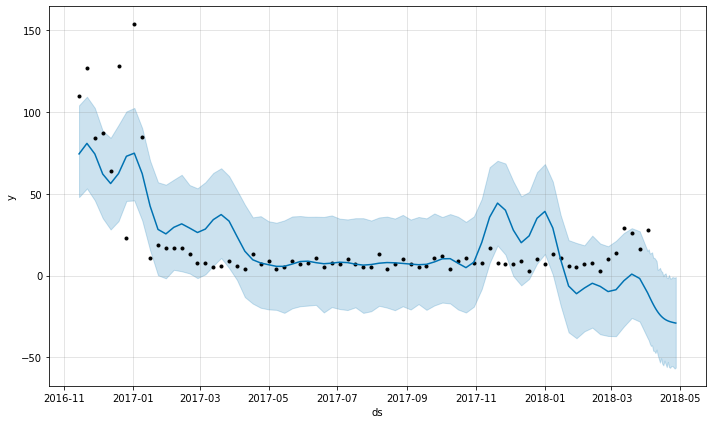

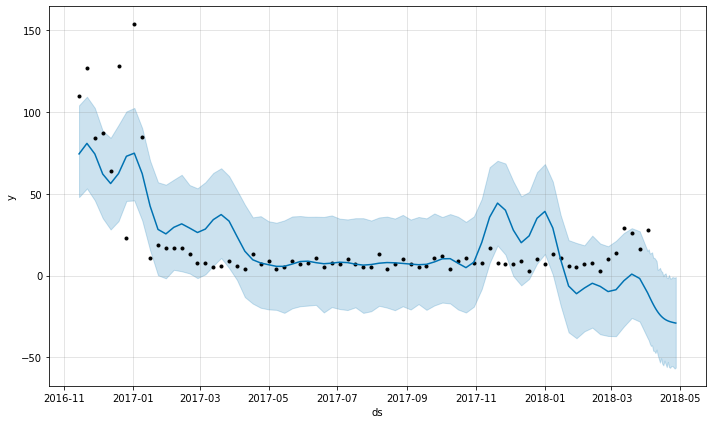

In [74]:
model.plot(results_df)

In [95]:
prophet_models = dict()
y_test = []
y_test_pred = []

for sku in skus:
  df_sku = sales[sales['sku'] == sku]
  prophet_df = df_sku[['week', 'weekly_sales']].rename(columns = {'week': 'ds', 'weekly_sales': 'y'})
  split_idx = int(len(prophet_df)*0.75)
  train, test = prophet_df[:split_idx], prophet_df[split_idx:]

  y_test += list(test['y'].values)

  model = Prophet(yearly_seasonality=True)
  model.add_country_holidays(country_name='US')
  model.fit(train)
  forecast = model.make_future_dataframe(periods = len(test), freq='D') #make daily predictions in the test sample
  results_df = model.predict(forecast)
  prophet_models[sku] = model

  y_test_pred += list(results_df.iloc[split_idx:, -1].values)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [96]:
print('Out of sample R2:',round(r2_score(y_test, np.array(y_test_pred)),3))
print('MSE:', round(mean_squared_error(y_test, np.array(y_test_pred)),3))

Out of sample R2: 0.013
MSE: 129448.87


### XGBoost

In [97]:
df = sales[sales['sku'] == 1]
df

,week,sku,weekly_sales,price,price-1,price-2,feat_main_page,trend,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,functionality_2,functionality_3,functionality_4,functionality_5,functionality_6,functionality_7,functionality_8,functionality_9,functionality_10,functionality_11,functionality_12,color_blue,color_gold,color_green,color_grey,color_none,color_pink,color_purple,color_red,color_white,vendor_2,vendor_3,vendor_4,vendor_5,vendor_6,vendor_7,vendor_8,vendor_9,vendor_10
0,2016-11-14,1,110.0,10.24,9.86,10.16,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,2016-11-21,1,127.0,8.27,10.24,9.86,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,2016-11-28,1,84.0,8.83,8.27,10.24,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,2016-12-05,1,87.0,8.98,8.83,8.27,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,2016-12-12,1,64.0,10.40,8.98,8.83,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,2018-08-27,1,16.0,29.56,30.56,30.56,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
94,2018-09-03,1,15.0,31.56,29.56,30.56,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
95,2018-09-10,1,21.0,25.49,31.56,29.56,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
96,2018-09-17,1,32.0,22.05,25.49,31.56,1,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [98]:
import xgboost as xgb

In [99]:
X = df.drop(['week', 'sku', 'weekly_sales'], axis = 1)
y = df[['weekly_sales']]

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [101]:
import time
start = time.time()
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], early_stopping_rounds=50, verbose=False)
pred = xgb_model.predict(X_test)
print(f'Time to train: {time.time() - start} seconds')

[13:19:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Time to train: 0.16165423393249512 seconds


In [139]:
results = pd.DataFrame({'Predicted': pred, 'Actual': y_test.values.flatten()})
print('Out of sample R2:',round(r2_score(results['Actual'].values, results['Predicted'].values),3))
print('MSE:', round(mean_squared_error(results['Actual'].values, results['Predicted'].values),3))

Out of sample R2: 0.42
MSE: 38.637


Decentralized Model

In [134]:
xgb_models = dict()
y_test_total = []
y_test_pred = []

start = time.time()

for sku in skus:
  df_sku = sales[sales['sku'] == sku]
  X = df_sku.drop(['week', 'sku', 'weekly_sales'], axis = 1)
  y = df_sku[['weekly_sales']]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
  
  y_test_total += list(y_test.values)

  xgb_model = xgb.XGBRegressor()
  xgb_model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], early_stopping_rounds=50, verbose=False)
  pred = xgb_model.predict(X_test)
  results = pd.DataFrame({'Predicted': pred, 'Actual': y_test.values.flatten()})
  
  y_test_pred += list(pred)

print(f'Time to train: {time.time() - start} seconds')

[13:35:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [138]:
print('Out of sample R2:',round(r2_score(np.array(y_test_total), np.array(y_test_pred)),3))
print('MSE:', round(mean_squared_error(np.array(y_test_total), np.array(y_test_pred)),3))

Out of sample R2: 0.58
MSE: 35236.801


Decentralized Model with Hyperparameter Tuning

In [180]:
import random
space={'max_depth': range(2, 11),
        'gamma': range(1, 10),
        'reg_alpha' : [random.uniform(40, 180) for i in range(100)],
        'reg_lambda' : [0.1*x for x in range(11)],
        'colsample_bytree' : [0.5+0.01*i for i in range(51)],
        'min_child_weight' : [0.1*i for i in range(100)],
        'n_estimators': range(100, 250, 10),
    }

In [181]:
from sklearn.model_selection import RandomizedSearchCV
xgb_models = dict()
y_test_total = []
y_test_pred = []

start = time.time()

for sku in skus:
  df_sku = sales[sales['sku'] == sku]
  X = df_sku.drop(['week', 'sku', 'weekly_sales'], axis = 1)
  y = df_sku[['weekly_sales']]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
  
  y_test_total += list(y_test.values)

  regressor = RandomizedSearchCV(xgb.XGBRegressor(), space, n_iter=12, random_state=6)
  search = regressor.fit(X_train, y_train)
  xgb_model = xgb.XGBRegressor(**search.best_params_)
  xgb_model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], early_stopping_rounds=50, verbose=False)
  pred = xgb_model.predict(X_test)

  xgb_models[sku] = xgb_model
  y_test_pred += list(pred)

print(f'Time to train: {time.time() - start} seconds')

[14:21:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [182]:
print('Out of sample R2:',round(r2_score(np.array(y_test_total), np.array(y_test_pred)),3))
print('MSE:', round(mean_squared_error(np.array(y_test_total), np.array(y_test_pred)),3))

Out of sample R2: 0.613
MSE: 45953.119
